In [1]:
import sys 
import io
import os
import cv2
import itertools

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
import random

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import tensorflow as tf

In [4]:
plt.style.use('seaborn-darkgrid')

# 1. Vamos a comenzar con la exploración de los datos. 

Tengo al momento tres data sets, cada uno con sus carateristicas:
* [Data Set Mateusz Buda](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)
* [Data Set Sartaj](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)
* [Data Set Navoneel](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)

Vamos a realizar los análisis por serparado. 

Es muy imporante notar que no tienen en principio caracteristicas entre los conjutos de datos. La razón de tenerlos será o bien buscar una forma de poder crear un data set más grande o bien buscar el set de datos que cubra las necesidades del proyecto. 

## 1.1 Set de Sartaj

La estructura del data set de Sartaj es la siguiente:
```
.
|
└───data
    │
    └───brain_MRI_Sartaj
        │
        |───Training
        │   │   
        │   │───pituitary_tumor
        |   |   |   p*.jpg
        |   │   │   ...
        |   |
        |   |───no_tumor
        |   |   |   image*.jpg
        |   │   │   ...
        |   |
        |   |───glioma_tumor
        |   |   |   gg*.jpg
        |   │   │   ...
        |   |
        |   └───meningioma_tumor
        |       |   m1*.jpg
        |       │   ...
        |
        └───Training
            │   
            │───pituitary_tumor
            |   |   p*.jpg
            │   │   ...
            |
            |───no_tumor
            |   |   image*.jpg
            │   │   ...
            |
            |───glioma_tumor
            |   |   gg*.jpg
            │   │   ...
            |
            └───meningioma_tumor
                |   m1*.jpg
                │   ...
    
    

```
Vamos a realizar el análsis explotario con los datos de Trainig.

En lugar de hacer un symlink prefiero usar varibles para guardar los paths absolutos.

In [5]:
#Este es nuestro directorio Training
MAINFOLDER = '../data/brain_MRI_Sartaj/Training/' 

In [6]:
#Acá itearmos para obtener los subdirectios de Training
SUBDIRS = os.listdir(MAINFOLDER)

In [6]:
def load_images_from_folder(folder,verbose=0,color=1):
    """
    Esta función toma un path e itera sobre los
    elementos del path para leer imágenes
    
    
    """
    images,not_images = [],[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),color)
        if img is not None:
            images.append(img)
        else:
            not_images.append(filename)
    if verbose !=0:
        print('{} tiene {} archivos que no son imágenes'.format(folder,len(not_images)))
    return images

In [8]:
# Acá cargamos las imágenes a color
imgs = {} #En este diccionario vamos a guardar los objetos images dentro de una lista y como key su parent folder
for i in SUBDIRS:
    imgs[i] = load_images_from_folder(MAINFOLDER+i,1) #Marcamos Verbose = 1 para ver si se coló algún archivo que no era imagen

../data/brain_MRI_Sartaj/Training/pituitary_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/no_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/glioma_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/meningioma_tumor tiene 0 archivos que no son imágenes


In [9]:
# Acá cargamos las imágenes a blanco y negro
imgs_bw = {} #En este diccionario vamos a guardar los objetos images dentro de una lista y como key su parent folder
for i in SUBDIRS:
    imgs_bw[i] = load_images_from_folder(MAINFOLDER+i,verbose=1,color=0) #Marcamos Verbose = 1 para ver si se coló algún archivo que no era imagen y Color=0 para B&W

../data/brain_MRI_Sartaj/Training/pituitary_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/no_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/glioma_tumor tiene 0 archivos que no son imágenes
../data/brain_MRI_Sartaj/Training/meningioma_tumor tiene 0 archivos que no son imágenes


Ahora, vamos a realizar una cuadricula para ver un sampling de las imágenes que están dentro de nuestros set de training

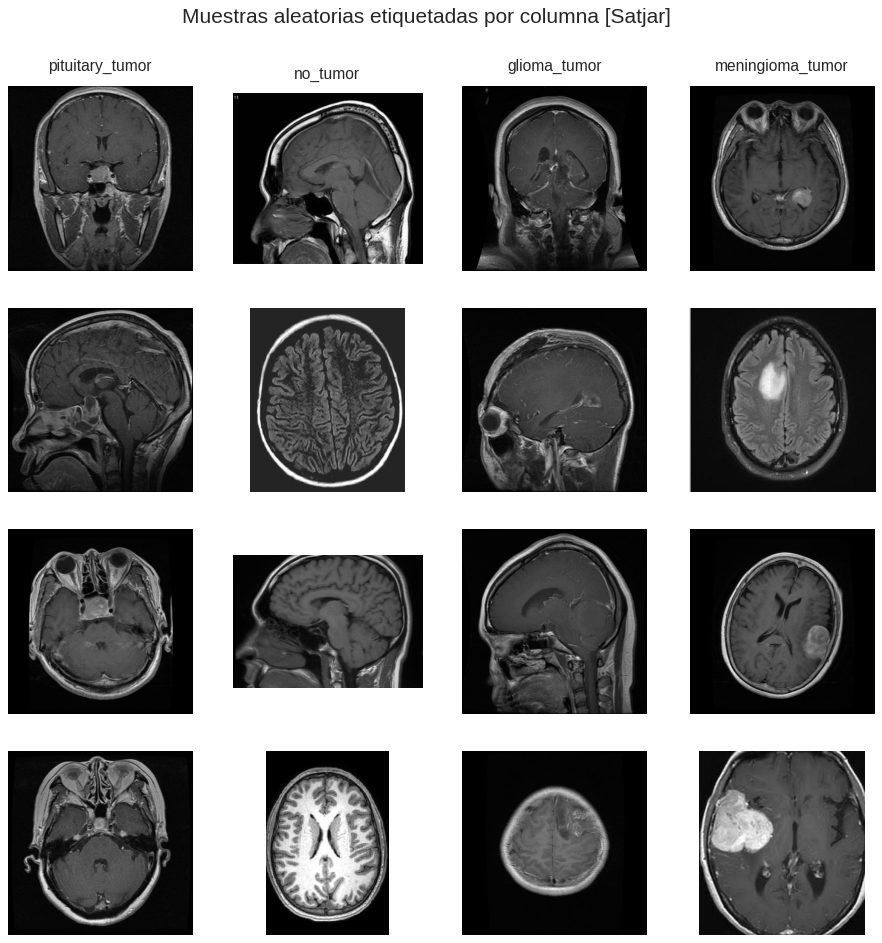

In [10]:
fig, ax = plt.subplots(4,4,figsize=(15,15),dpi=75)
for i,key in enumerate(imgs.keys()):
    for j,im in enumerate(random.choices(population=imgs[key],k=4)):
        ax[j,i].imshow(im)
        #ax[j,i].set_title(key)
        ax[j,i].set_axis_off()
        ax[0][i].set_title(key,fontsize=15).set_position([.5, 1.05])
        
fig.suptitle('Muestras aleatorias etiquetadas por columna [Satjar]',y=0.95,fontsize=20)
        
plt.show()

Una discusión que se puede desarrollar es si están bien etiquetadas las imágenes. De no estar así puede llevarnos a que el modelo aprenda _spurious patterns_ y nunca converger o bien overfitting -entre más outliers existan dentro de una misma clase más difícil será crear un modelo general ya que para poder capturarlos las fronteras de desición se tiene que extender o bien desarrollar extensiones para cubrir esos púntos específicos-

Ahora bien, vamos a ver que tan balanceada está la data de cada conjunto.

In [11]:
dummy = {'category':[], 'size':[]}
for i in imgs.keys():
    dummy['category'].append(i)
    dummy['size'].append(len(imgs[i]))

In [12]:
df = pd.DataFrame(dummy)

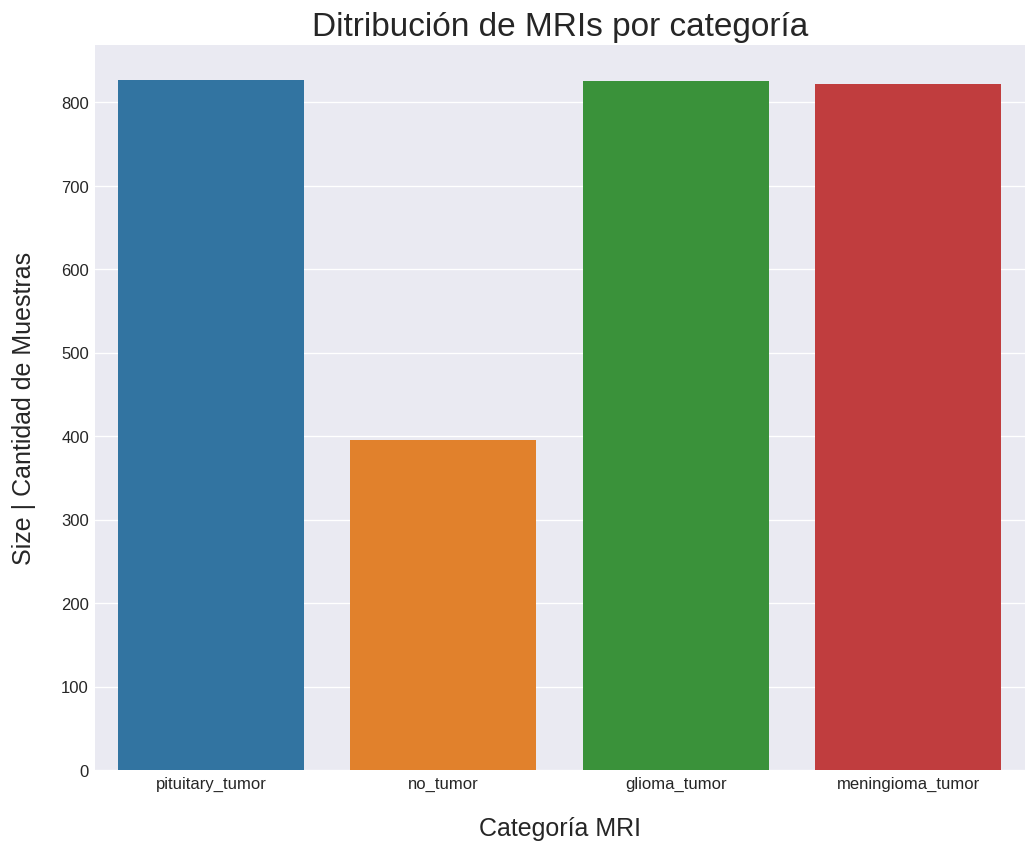

In [13]:
fix,ax = plt.subplots(1,1,dpi=120,figsize=(10,8))
sbn.barplot(
    data = df,
    x = 'category',
    y = 'size',
    ax = ax
)
ax.set_title('Ditribución de MRIs por categoría',fontsize=20)
ax.set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax.set_xlabel('Categoría MRI',fontsize=15,labelpad=15)


plt.show()

Es importante notar que estamos frente a un problema de **Imbalanced Data** (ratio ~2:1). Afortunadamente para la parte de clasificación vamos a poder usar algunos métodos ya conocidos, para una revesión se recomienda la entrada del blog _Machine Learning Mastery_ [A Gentle Introduction to Imbalanced Classification](https://machinelearningmastery.com/what-is-imbalanced-classification/)

Otra cosa que será bastante importante es revisar la distribución de tamaños de las imágenes de cada categoría. Es recomendable simple realizar un resize pero por lo pronto vamos a ver cómo se distribuyen los tamaños de los MRIs.

In [33]:
sizes = lambda x: [str(i.shape[0])+'x'+str(i.shape[1]) for i in x]

In [15]:
dummy = {'category':[],'sizes':[]}
for i in imgs.keys():
    dummy['category'] = dummy['category'] + [i]*len(imgs[i])
    dummy['sizes'] = dummy['sizes'] + sizes(imgs[i])

In [16]:
df = pd.DataFrame(dummy)
df['dummy'] = 1
df_dummy = df.groupby(['category','sizes']).agg({'dummy':'sum'}).reset_index()

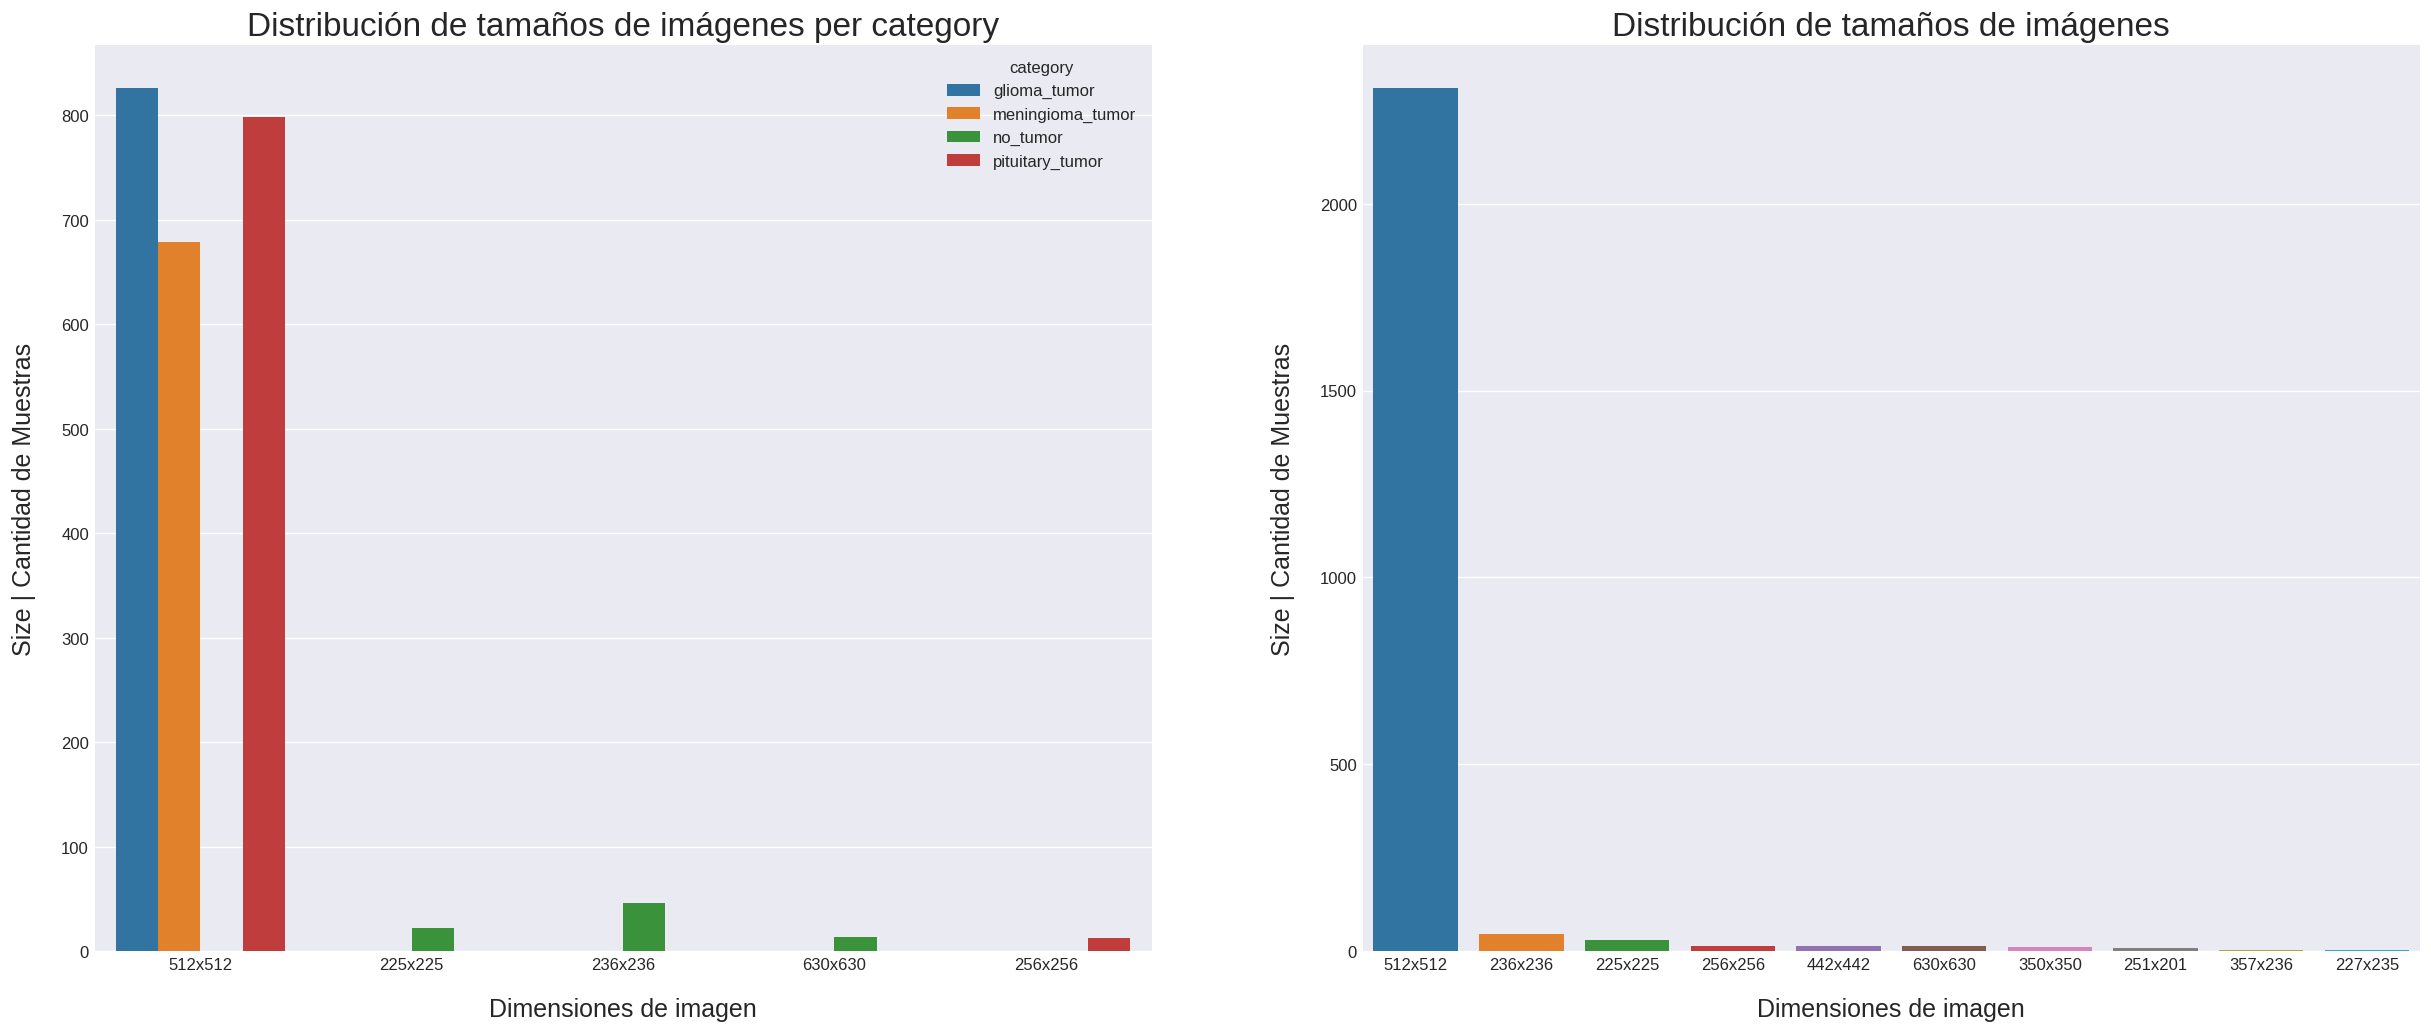

In [17]:
fix,ax = plt.subplots(1,2,dpi=120,figsize=(25,10))
sbn.barplot(
    data = df_dummy[df_dummy.dummy>10],
    x = 'sizes',
    y = 'dummy',
    hue = 'category',
    ax = ax[0]
)
ax[0].set_title('Distribución de tamaños de imágenes per category',fontsize=20)
ax[0].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[0].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)

sbn.barplot(
    x = df.sizes.value_counts().index.values[:10],
    y = df.sizes.value_counts().values[:10],
    ax=ax[1]
)
ax[1].set_title('Distribución de tamaños de imágenes',fontsize=20)
ax[1].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[1].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)


plt.show()

Lo anterior nos deja claro que nos solamente tenemos las categorías desbalanceadas sino también los tamaños. Afortunadamete esto es más sencillo de hacer que lidiar con los datos no balanceados. 

In [53]:
def resize(array,he=250,wi=250):
    """
    This function resizes an array of cv2.imread files
    to he x wi images. It does not matter if they were
    read using cv2.IMREAD_COLOR, cv2.IMREAD_GRAYSCALE
    or cv2.IMREAD_UNCHANGED
    
    Parameters
    ----------
    array : list, numpy.narray, tuple, set
        Array of cv2.imread files
    he : int
        Height of resised image
    wi : int
        Width of resised image
        
    Returns
    -------
    array
    An array of cv2.imread files resised to he x wi
    """
    return [cv2.resize(img,(he,wi)) for img in array]

In [19]:
for i in imgs.keys():
    imgs[i] = resize(imgs[i])

In [20]:
dummy = {'category':[],'sizes':[]}
for i in imgs.keys():
    dummy['category'] = dummy['category'] + [i]*len(imgs[i])
    dummy['sizes'] = dummy['sizes'] + sizes(imgs[i])
    
df = pd.DataFrame(dummy)
df['dummy'] = 1
df_dummy = df.groupby(['category','sizes']).agg({'dummy':'sum'}).reset_index()

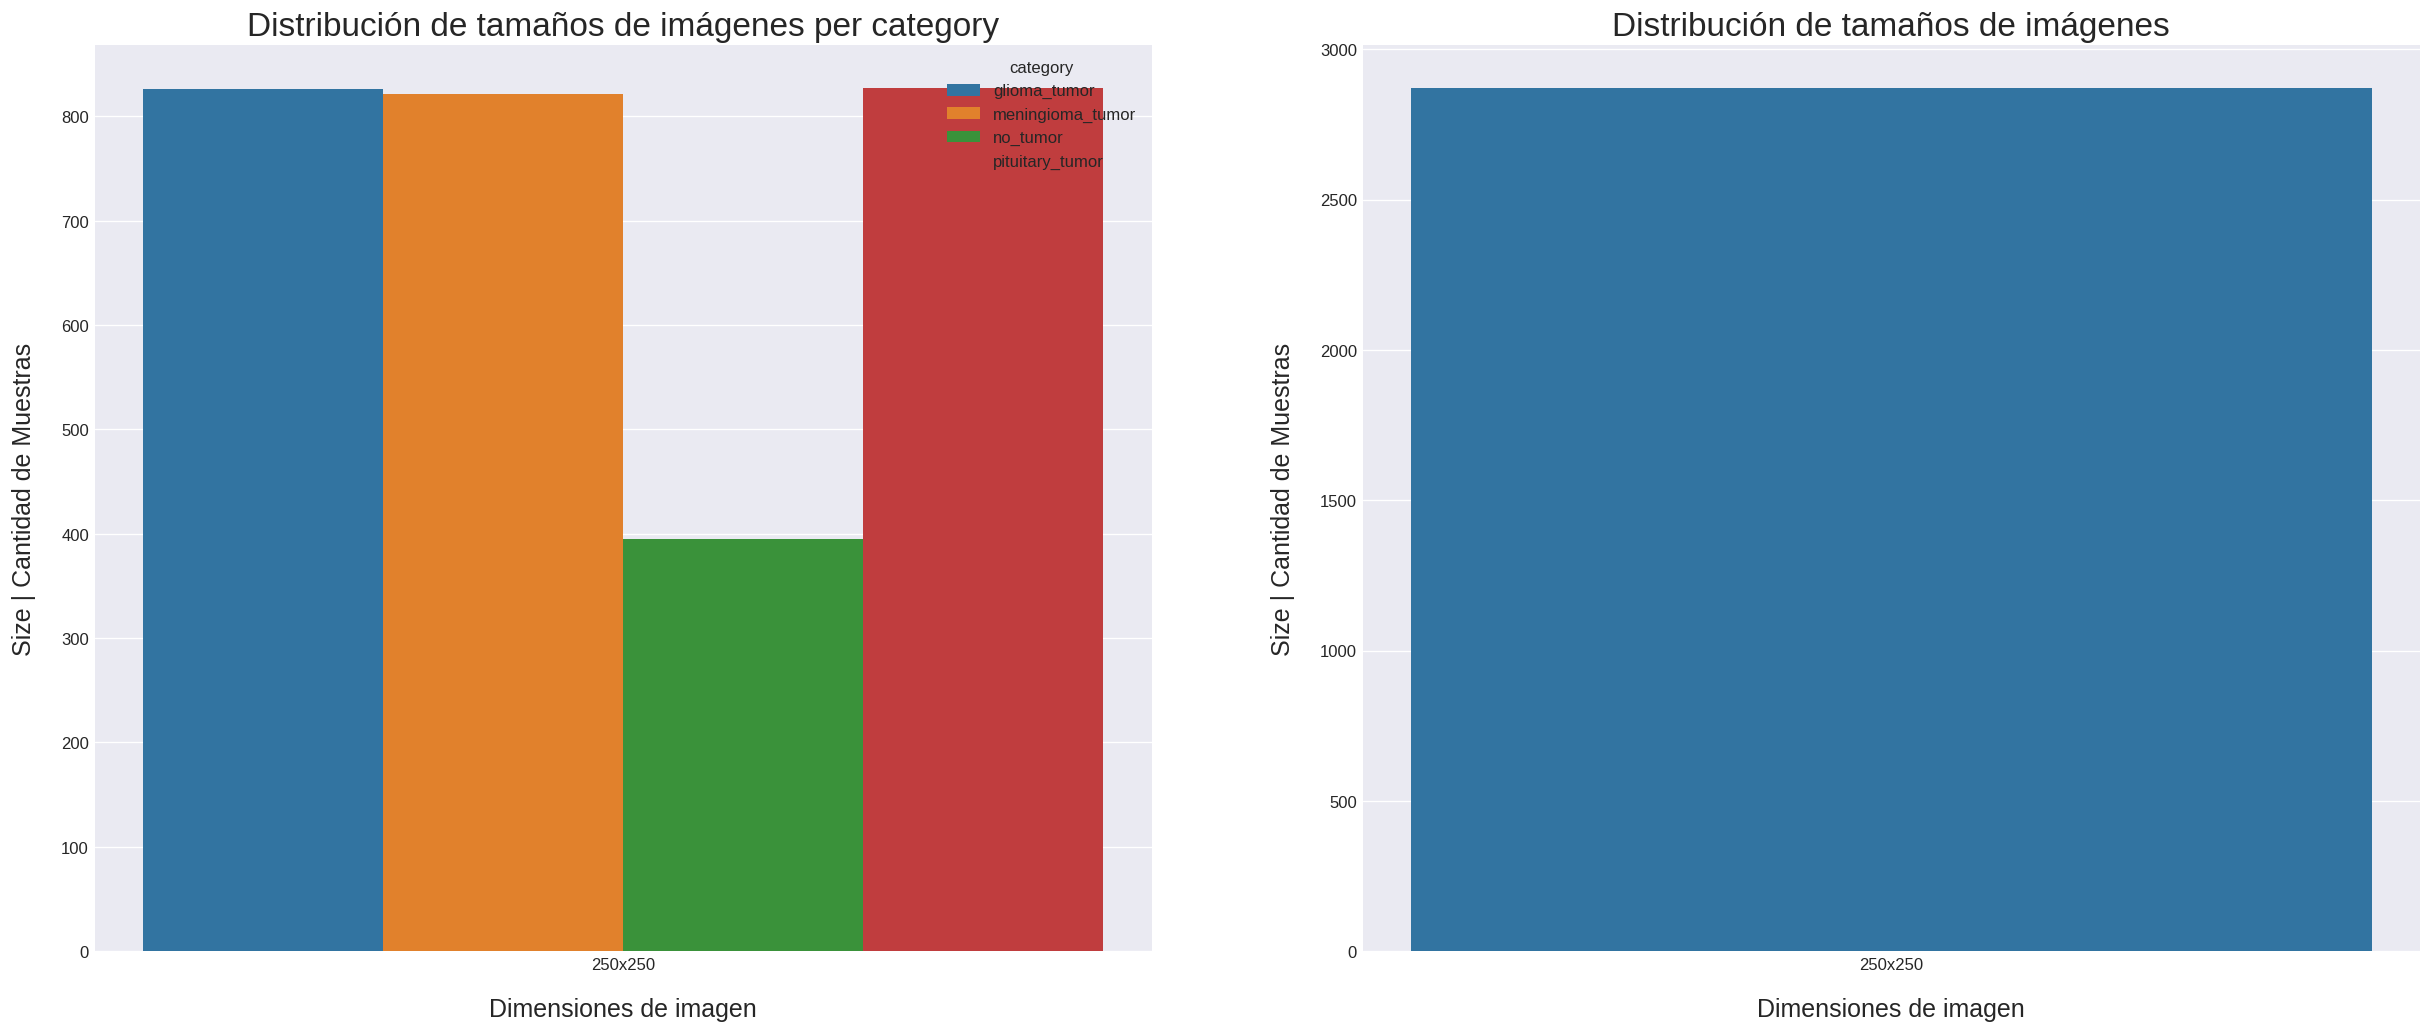

In [21]:
fix,ax = plt.subplots(1,2,dpi=120,figsize=(25,10))
sbn.barplot(
    data = df_dummy[df_dummy.dummy>10],
    x = 'sizes',
    y = 'dummy',
    hue = 'category',
    ax = ax[0]
)
ax[0].set_title('Distribución de tamaños de imágenes per category',fontsize=20)
ax[0].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[0].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)

sbn.barplot(
    x = df.sizes.value_counts().index.values[:10],
    y = df.sizes.value_counts().values[:10],
    ax=ax[1]
)
ax[1].set_title('Distribución de tamaños de imágenes',fontsize=20)
ax[1].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[1].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)


plt.show()

Así ya quedan bién balancedos los tamaños.

Por último, vamos a ver si tenemos un patrón evidente mediante aplicar un k-means a nuestros datos. 

In [59]:
def group_assignment(data,centroids):
    grouping_vec_c = np.zeros(len(data))
    for i in range(len(data)):
        dist = np.zeros(len(centroids))
        for j in range(len(centroids)):
            dist[j] = np.linalg.norm(data[i] - centroids[j])
        min_dist = min(dist)
        for j in range(len(centroids)):
            if min_dist == dist[j]:
                grouping_vec_c[i] = j+1
    return grouping_vec_c

def update_centroid(data, grouping, centroids):
    new_centroids = [];
    for i in range(len(centroids)):
        cent = np.zeros(len(data[0]))
        count = 0
        for j in range(len(data)):
            if grouping[j] == (i+1):
                cent = cent+data[j]
                count += 1
        group_average = cent/count
        new_centroids.append(group_average)
    return new_centroids

def clustering_objective(data, grouping, centroids):
    J_obj = 0
    for i in range(len(data)):
        for j in range(len(centroids)):
            if grouping[i] == (j+1):
                J_obj += np.linalg.norm(data[i] - centroids[j])**2
    J_obj = J_obj/len(data)
    return J_obj

def Kmeans_alg(data, centroids):
    iteration = 0
    J_obj_vector = []
    Stop = False
    while Stop == False:
        grouping = group_assignment(data, centroids)
        new_centroids = update_centroid(data, grouping, centroids)
        J_obj = clustering_objective(data, grouping,new_centroids)
        J_obj_vector.append(J_obj)
        iteration += 1
        if np.linalg.norm(np.array(new_centroids) - np.array(centroids)) < 1e-6:
            Stop = True
        else:
            centroids = new_centroids
    return new_centroids, grouping, J_obj_vector, iteration

Si hay un patrón naïve seguro lo podemos encontrar con una buena inicialización de K-means.

In [23]:
for i in imgs.keys():
    imgs_bw[i] = resize(imgs_bw[i])

All_data =[]
for i in imgs.keys():
    All_data = All_data+[j.reshape(62500) for j in imgs_bw[i]]

In [24]:
A = Kmeans_alg(All_data,random.choices(All_data,k=4))

In [25]:
a = list(itertools.product(list(range(2)),list(range(2))))

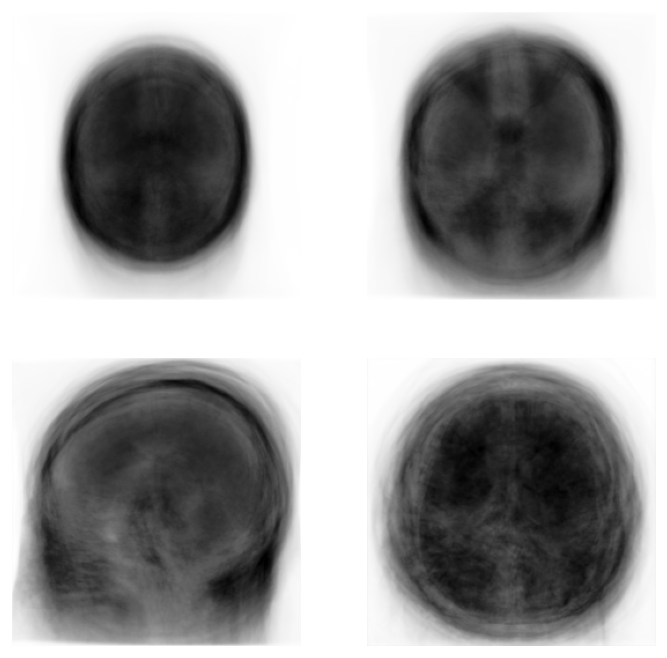

In [26]:
fig, ax = plt.subplots(2,2,figsize=(7,7),dpi=120)
for i,j in zip(a,A[0]):
        ax[i[0]][i[1]].imshow(j.reshape(250,250))
        ax[i[0]][i[1]].set_axis_off()
plt.show()

El patrón naïve que encontramos fue la forma y la toma del MRI. 

In [27]:
dummy = {'img':All_data,'cat':A[1]}

In [28]:
df = pd.DataFrame(dummy)

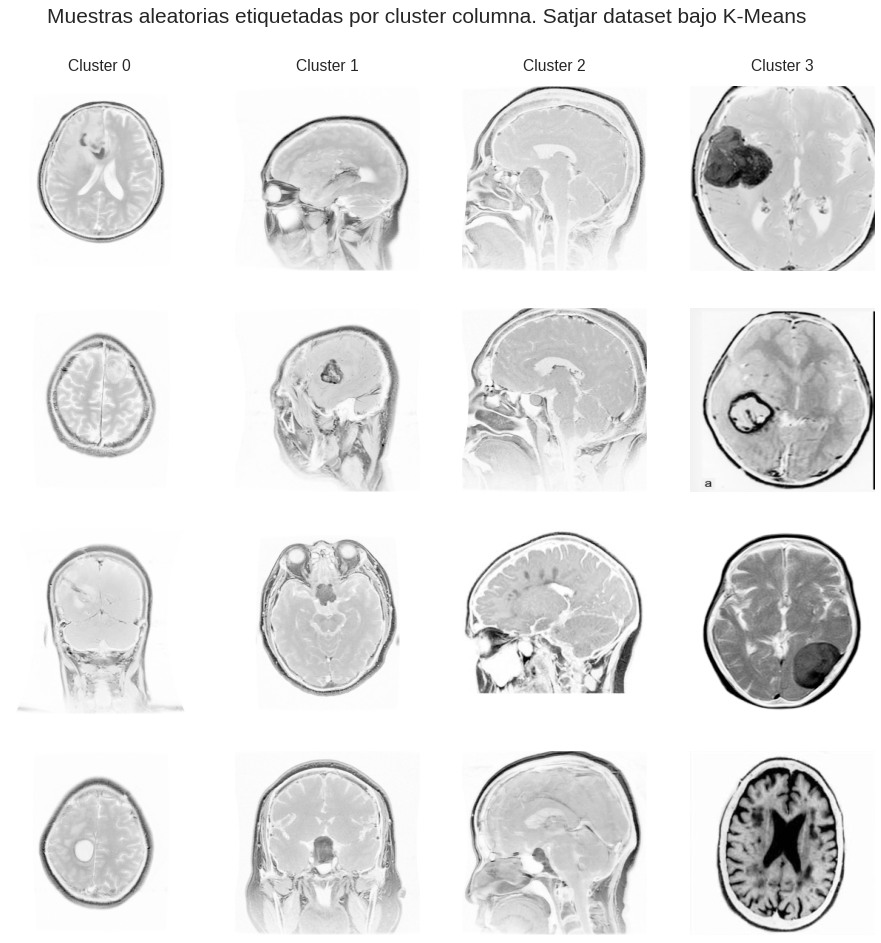

In [33]:
fig, ax = plt.subplots(4,4,figsize=(15,15),dpi=75)
for i in range(4):
    for j,im in enumerate(df[df.cat == i+1].sample(n=4).values):
        ax[j,i].imshow(im[0].reshape(250,250))
        #ax[j,i].set_title(i)
        ax[j,i].set_axis_off()
        ax[0][i].set_title('Cluster {}'.format(i),fontsize=15).set_position([.5, 1.05])
        
fig.suptitle('Muestras aleatorias etiquetadas por cluster columna. Satjar dataset bajo K-Means',y=0.95,fontsize=20)
        
plt.show()

Notemos que K-Means puede ver carecteristicas que para nuestro problema son en sí mismas macro. En lugar de captar las caracteristias relacionadas a la aparición de un tumor toma aquellas relacionadas a las de la forma en que la MRI fue tomada (plano). 

## 1.2 Set de Navoneel

Ahora vamos a realizar una exploración con la misma que con el set de Sartaj.

La estructura del data set de Navoneel es la siguiente:
```
.
|
└───data
    │
    └───brain_MRI_Navoneel
        │
        |───yes   
        |   |   Y*.jpg
        |   │   ...
        |
        └───no
            |   *no.jpg
            │   ...
    
    

```
En este caso únicamente se dividen en categorías `yes` y `no` que serán las etiquetas inferidas por la organización de las carpetas. 

In [7]:
#Este es nuestro directorio principal
MAINFOLDER_NAVONEEL = '../data/brain_MRI_Navoneel/' 

In [15]:
#Acá itearmos para obtener los subdirectios de Navoneel
SUBDIRS = os.listdir(MAINFOLDER_NAVONEEL)

In [16]:
# Por construicción el set está iterado sobre sí mismo. Hay dentro una carpeta
# que se llama brain_tumor_dataset que contiene las carpetas de yes/no y hay dentro
# la misma data que en las capetas externas. Por esto, vamos a excluir el subdir
# brain_tumor_dataset
print('Así es sin exclusiones: ',SUBDIRS,sep='\n')
SUBDIRS = [s for s in SUBDIRS if not 'brain' in s]
print('Así es realizando la exclusión: ',SUBDIRS,sep='\n')

Así es sin exclusiones: 
['brain_tumor_dataset', 'no', 'yes']
Así es realizando la exclusión: 
['no', 'yes']


In [17]:
# Acá cargamos las imágenes a color
imgs_nov = {} #En este diccionario vamos a guardar los objetos images dentro de una lista y como key su parent folder
for i in SUBDIRS:
    imgs_nov[i] = load_images_from_folder(MAINFOLDER_NAVONEEL+i,1) #Marcamos Verbose = 1 para ver si se coló algún archivo que no era imagen

../data/brain_MRI_Navoneel/no tiene 0 archivos que no son imágenes
../data/brain_MRI_Navoneel/yes tiene 0 archivos que no son imágenes


In [19]:
# Acá cargamos las imágenes a blanco y negro
imgs_nov_bw = {} #En este diccionario vamos a guardar los objetos images dentro de una lista y como key su parent folder
for i in SUBDIRS:
    imgs_nov_bw[i] = load_images_from_folder(MAINFOLDER_NAVONEEL+i,verbose=1,color=0) #Marcamos Verbose = 1 para ver si se coló algún archivo que no era imagen y Color=0 para B&W

../data/brain_MRI_Navoneel/no tiene 0 archivos que no son imágenes
../data/brain_MRI_Navoneel/yes tiene 0 archivos que no son imágenes


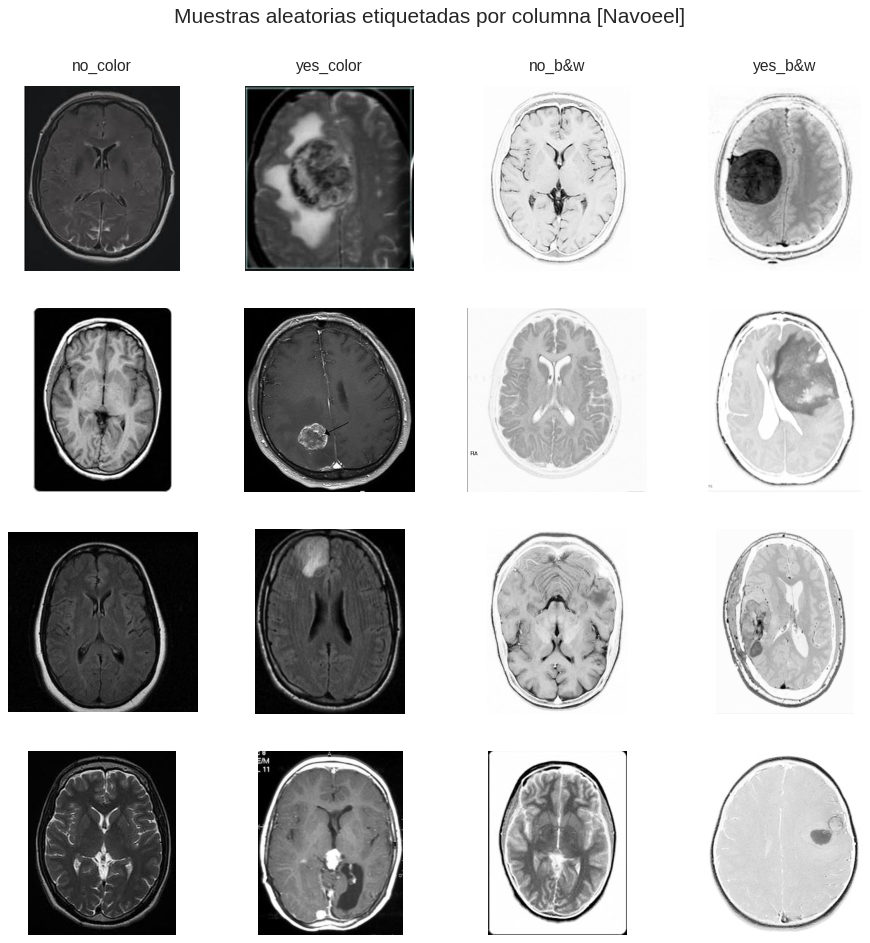

In [26]:
fig, ax = plt.subplots(4,4,figsize=(15,15),dpi=75)
for i,key in enumerate(imgs_nov.keys()):
    for j,im in enumerate(random.choices(population=imgs_nov[key],k=4)):
        ax[j,i].imshow(im)
        #ax[j,i].set_title(key)
        ax[j,i].set_axis_off()
        ax[0][i].set_title(key+'_color',fontsize=15).set_position([.5, 1.05])
        
for i,key in enumerate(imgs_nov_bw.keys()):
    for j,im in enumerate(random.choices(population=imgs_nov_bw[key],k=4)):
        ax[j,i+2].imshow(im)
        #ax[j,i].set_title(key)
        ax[j,i+2].set_axis_off()
        ax[0][i+2].set_title(key+'_b&w',fontsize=15).set_position([.5, 1.05])
        
fig.suptitle('Muestras aleatorias etiquetadas por columna [Navoeel]',y=0.95,fontsize=20)
        
plt.show()

Ahora bien, vamos a realizar el análisis de tamaños nuevamente

In [28]:
dummy = {'category':[], 'size':[]}
for i in imgs_nov.keys():
    dummy['category'].append(i)
    dummy['size'].append(len(imgs_nov[i]))
df = pd.DataFrame(dummy)

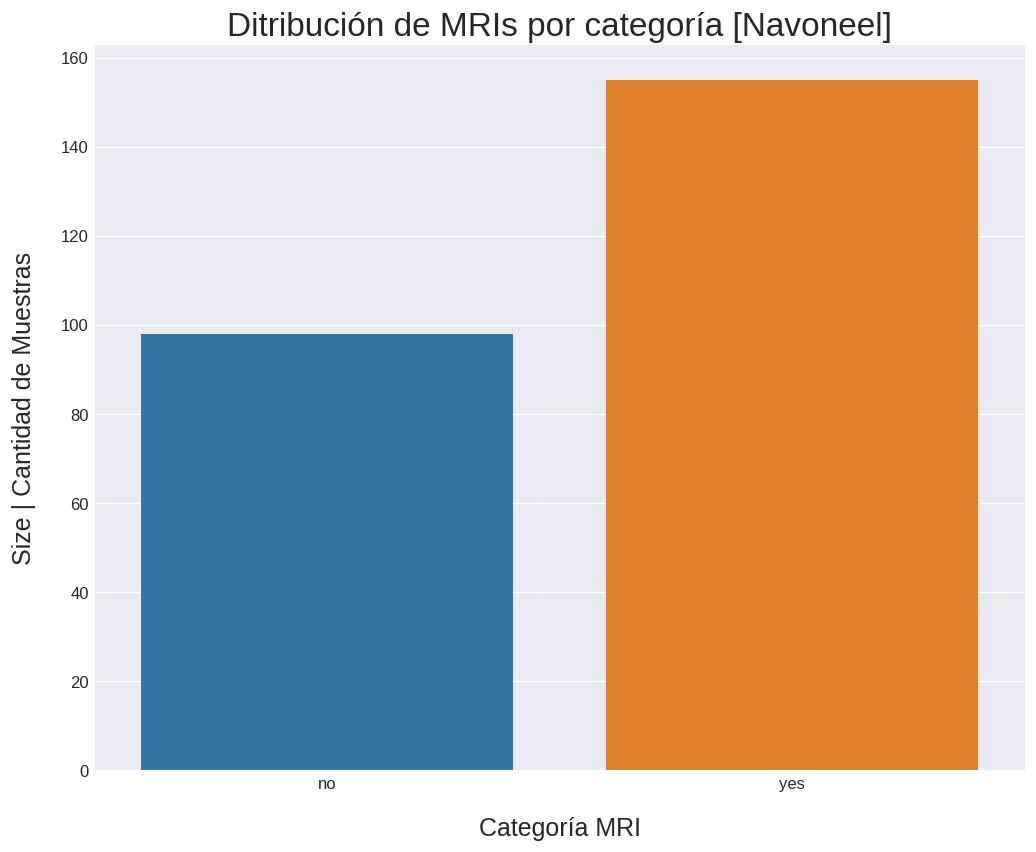

In [30]:
fix,ax = plt.subplots(1,1,dpi=120,figsize=(10,8))
sbn.barplot(
    data = df,
    x = 'category',
    y = 'size',
    ax = ax
)
ax.set_title('Ditribución de MRIs por categoría [Navoneel]',fontsize=20)
ax.set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax.set_xlabel('Categoría MRI',fontsize=15,labelpad=15)


plt.show()

Nuevamente tenemos un set de datos no balanceados.
Una idea interesante es poder usar las muestras con etiqueta `no` y usarlas para poder balancear el set de datos de Sartaj respecto a las no tumorales. De igual forma podemos usar las de etiqueta `yes` para poder hacer cross-validation; si bien no tenemos la clase de tumor que es, con un modelo bien entrenado, deberíamos de poder detectar la presencia de un tumor y además inferir su clase. 

Ahora vamos a revisar la distribución de tamaños.  
Una discusión muy importante es que si la mayoría (superior al 0.2) del set contiene imágenes de distintos tamaños realizando resizes entonces perderemos cálidad en las imágenes y esto puede dañar nuestro entrenamiento. Continuando en la misma línea, para poder solventar problemas que vamos a comenzar a acarrear derivado de lod problemas que se han comentado vamos a usar técnicas de _Data Augmentation_ (para más información ver las entredas de [TensorFlow:Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) y [Shorten & Khoshgoftaar, 2019](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0))

In [35]:
dummy = {'category':[],'sizes':[]}
for i in imgs_nov.keys():
    dummy['category'] = dummy['category'] + [i]*len(imgs_nov[i])
    dummy['sizes'] = dummy['sizes'] + sizes(imgs_nov[i])
    
df = pd.DataFrame(dummy)
df['dummy'] = 1
df_dummy = df.groupby(['category','sizes']).agg({'dummy':'sum'}).reset_index()

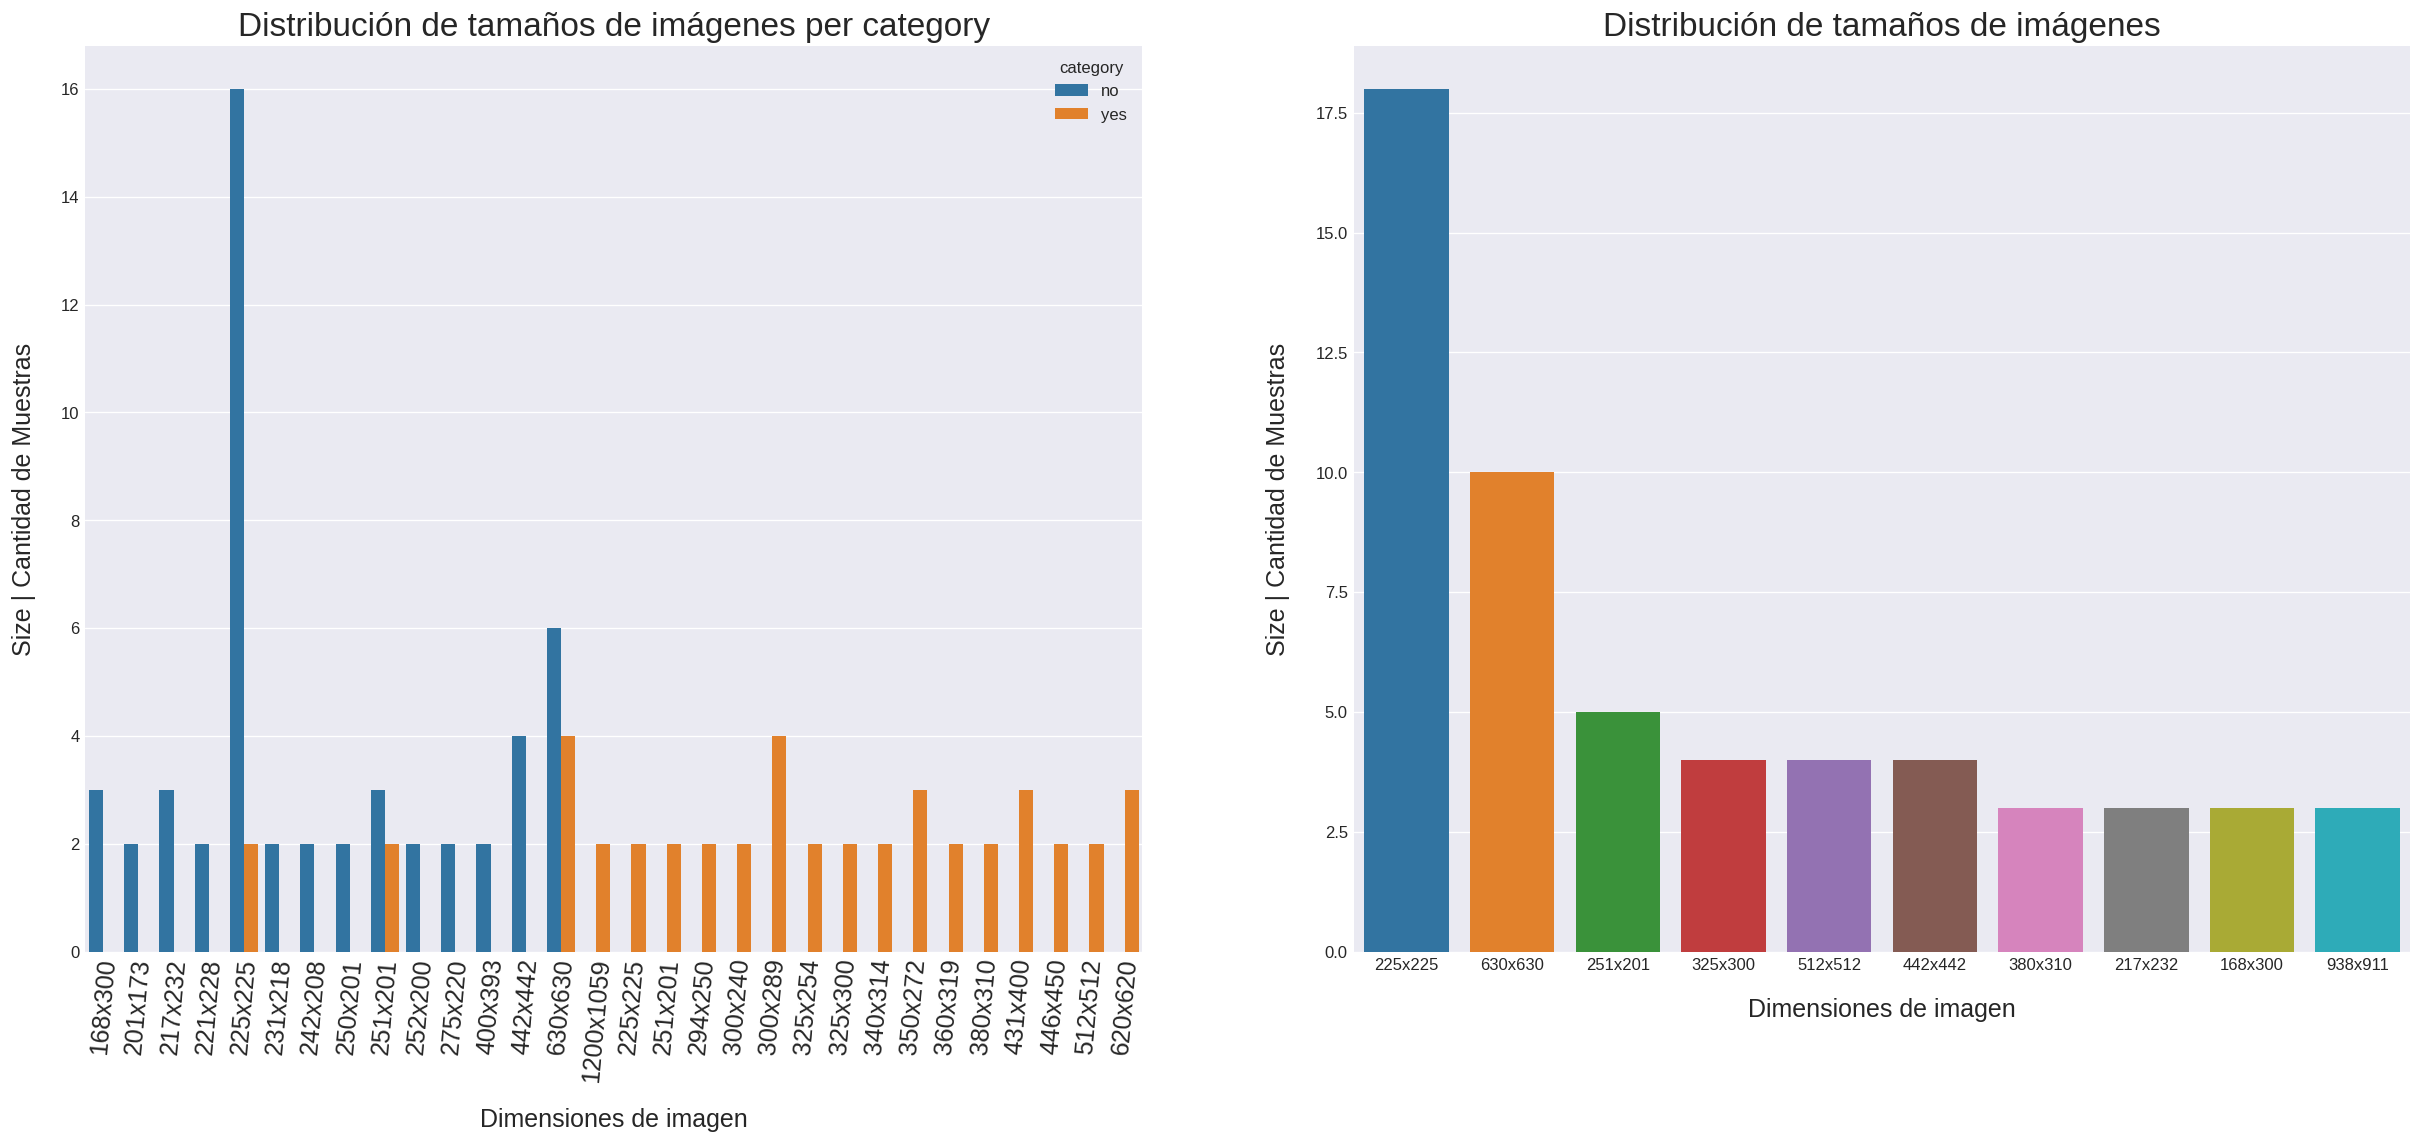

In [52]:
fix,ax = plt.subplots(1,2,dpi=120,figsize=(25,10))
sbn.barplot(
    data = df_dummy[df_dummy.dummy>1],
    x = 'sizes',
    y = 'dummy',
    hue = 'category',
    ax = ax[0],
)
ax[0].set_title('Distribución de tamaños de imágenes per category',fontsize=20)
ax[0].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[0].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)
ax[0].set_xticklabels(df_dummy[df_dummy.dummy>1].sizes,rotation=85,fontsize=15,ha='center')


sbn.barplot(
    x = df.sizes.value_counts().index.values[:10],
    y = df.sizes.value_counts().values[:10],
    ax=ax[1]
)
ax[1].set_title('Distribución de tamaños de imágenes',fontsize=20)
ax[1].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[1].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)


plt.show()

Acá tenemos los tamños muy dispersos, será de esperar que esto nos afecte directo hacia el entreamiento de las redes. 

Por último, vamos a realizar un reshape de todas las imágenes del set. 

In [55]:
for i in imgs_nov.keys():
    imgs_nov_bw[i] = resize(imgs_nov_bw[i])

In [57]:
dummy = {'category':[],'sizes':[]}
for i in imgs_nov.keys():
    dummy['category'] = dummy['category'] + [i]*len(imgs_nov_bw[i])
    dummy['sizes'] = dummy['sizes'] + sizes(imgs_nov_bw[i])
    
df = pd.DataFrame(dummy)
df['dummy'] = 1
df_dummy = df.groupby(['category','sizes']).agg({'dummy':'sum'}).reset_index()

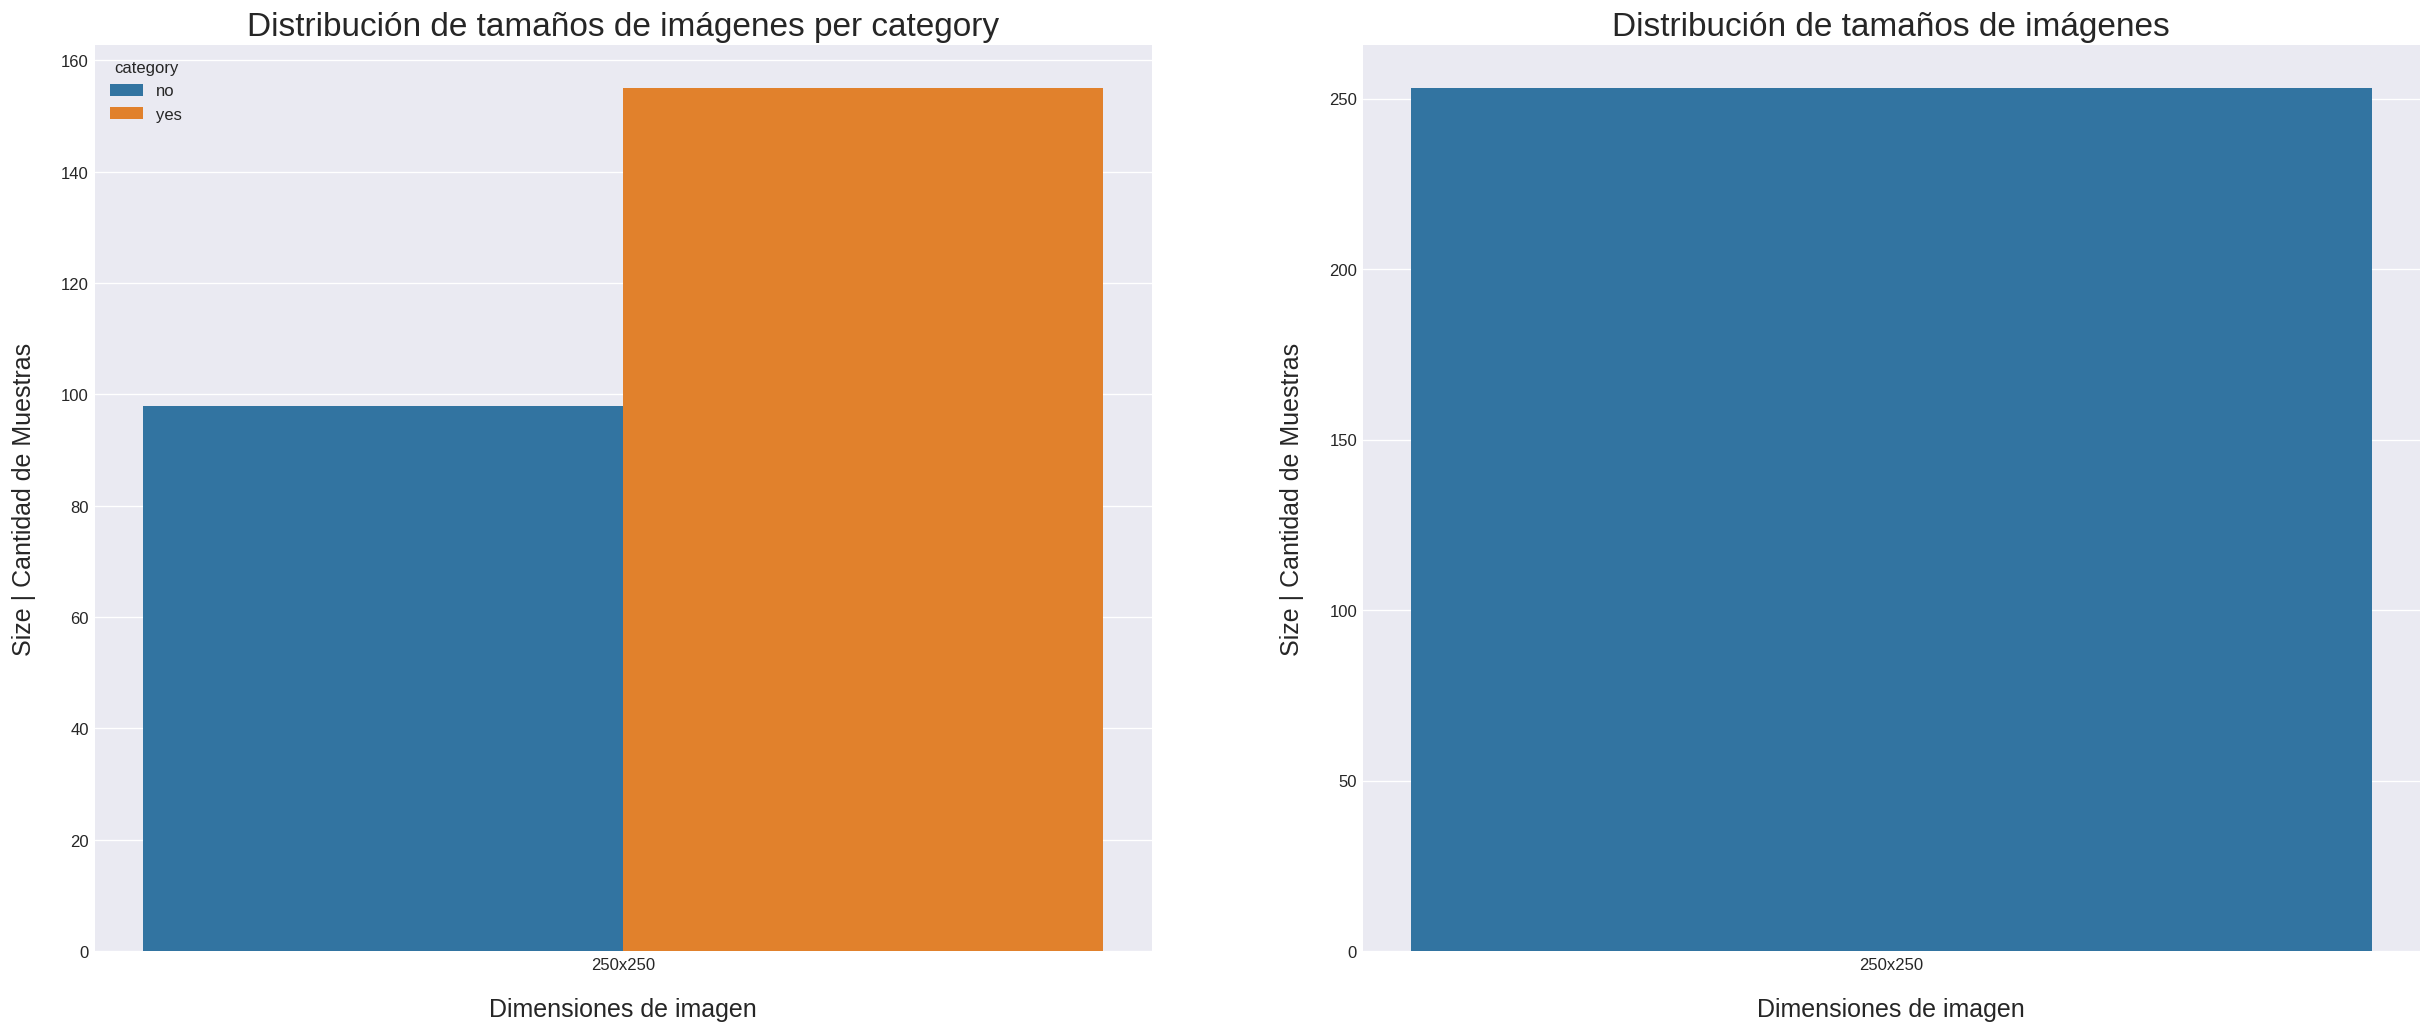

In [58]:
fix,ax = plt.subplots(1,2,dpi=120,figsize=(25,10))
sbn.barplot(
    data = df_dummy[df_dummy.dummy>10],
    x = 'sizes',
    y = 'dummy',
    hue = 'category',
    ax = ax[0]
)
ax[0].set_title('Distribución de tamaños de imágenes per category',fontsize=20)
ax[0].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[0].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)

sbn.barplot(
    x = df.sizes.value_counts().index.values[:10],
    y = df.sizes.value_counts().values[:10],
    ax=ax[1]
)
ax[1].set_title('Distribución de tamaños de imágenes',fontsize=20)
ax[1].set_ylabel('Size | Cantidad de Muestras',fontsize=15,labelpad=15)
ax[1].set_xlabel('Dimensiones de imagen',fontsize=15,labelpad=15)


plt.show()

Así pues ya están escaladas todas nuestras imágenes.  

Por último, vamos a relalizar cuatro clústers con K-Means. 

In [78]:
All_data =[]
for i in imgs_nov_bw.keys():
    All_data = All_data+[j.reshape(62500) for j in imgs_nov_bw[i]]

In [79]:
A = Kmeans_alg(All_data,random.choices(All_data,k=4))

In [80]:
a = list(itertools.product(list(range(2)),list(range(2))))

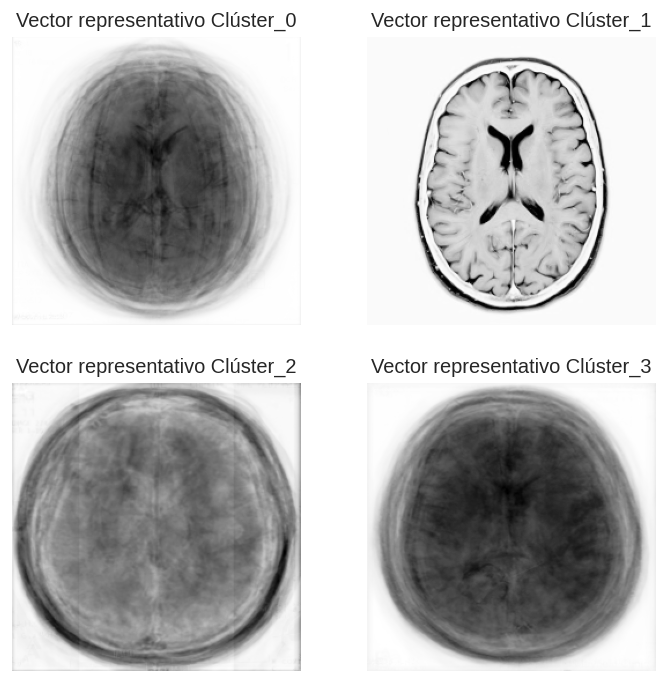

In [81]:
fig, ax = plt.subplots(2,2,figsize=(7,7),dpi=120)
for i,j,k in zip(a,A[0],[0,1,2,3]):
        ax[i[0]][i[1]].imshow(j.reshape(250,250))
        ax[i[0]][i[1]].set_title('Vector representativo Clúster_{}'.format(k))
        ax[i[0]][i[1]].set_axis_off()
        
plt.show()

Acá podemos notar que las imágenes escaladas (_resized_) sí introducen ruido en la clusterización. 

In [82]:
dummy = {'img':All_data,'cat':A[1]}
df = pd.DataFrame(dummy)

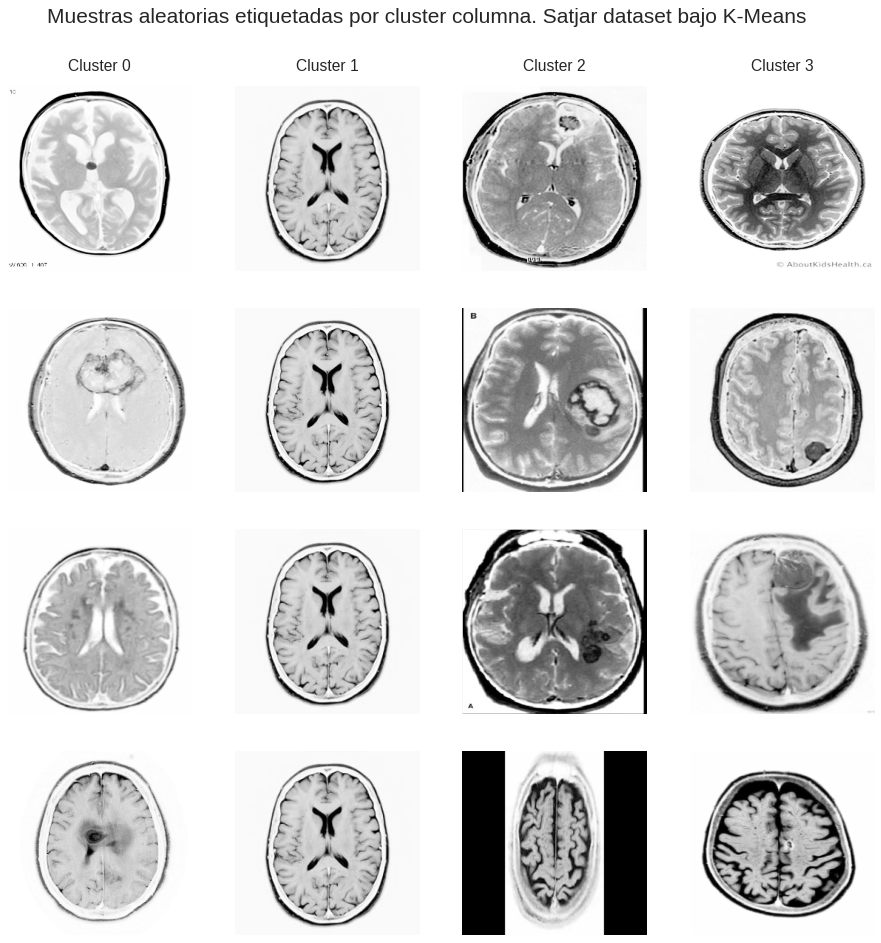

In [83]:
fig, ax = plt.subplots(4,4,figsize=(15,15),dpi=75)
for i in range(4):
    for j,im in enumerate(df[df.cat == i+1].sample(n=4,replace=True).values):
        ax[j,i].imshow(im[0].reshape(250,250))
        #ax[j,i].set_title(i)
        ax[j,i].set_axis_off()
        ax[0][i].set_title('Cluster {}'.format(i),fontsize=15).set_position([.5, 1.05])
        
fig.suptitle('Muestras aleatorias etiquetadas por cluster columna. Satjar dataset bajo K-Means',y=0.95,fontsize=20)
        
plt.show()

Nuevamente tenemos un clisterización por formas. Hay que notar que sí hay ruido introducido por el resize de las imágenes. 